In [4]:
%pylab inline
import condor, spimage, h5py
from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


/Users/benedikt/miniconda3/envs/py2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [105]:
index = 4
filename = '/Users/benedikt/data/LCLS/amol3416/phasing/cbx_selection_singles2_with_data.h5'
with h5py.File(filename, 'r') as f:
    image = f['data_1'][index]
    mask_cbx = f['mask_1'][index]
    #data_cnt = f['data'][index]
    #mask_cnt = f['mask'][index].astype(np.bool)
    runnr = f['runnr'][index]
    timestamp = f['timestamp'][index]

In [106]:
# Mask and background-removal
mask_sat = (image > 37)
mask = ~(mask_cbx.astype(np.bool)) & ~mask_sat
image[image < 0.5] = 0.

In [107]:
# Find the center 
x,y = spimage.find_center(image, mask, method='blurred', x0=0, y0=0, 
                              dmax=40, threshold=0.5, blur_radius=4)
    
# Crop around the center to 1024x1024
centery = int(image.shape[0]//2+y + 50)
centerx = int(image.shape[1]//2+x + 50)
data_padded = np.pad(image, 50, 'constant')
data_cropped = data_padded[centery-512:centery+512, centerx-512:centerx+512]
mask_padded  = np.pad(mask, 50, 'constant')
mask_cropped = mask_padded[centery-512:centery+512, centerx-512:centerx+512]

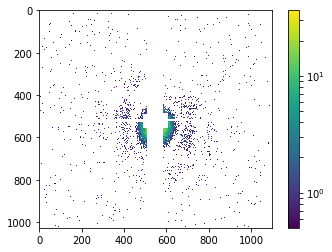

In [108]:
plt.figure()
plt.imshow(image*mask, norm=LogNorm())
plt.colorbar()
plt.show()

In [109]:
# Downsampling
data_ds, mask_ds = spimage.binImage(data_cropped, 8, msk=mask_cropped, output_binned_mask=True)
    
# Photon counting
data_cnt = np.round(data_ds)
mask_cnt = mask_ds == 64#~((mask_ds != 64) & (data_ds == 0))

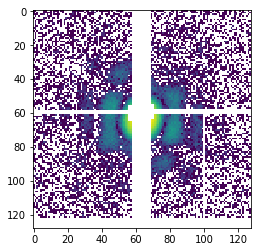

In [110]:
plt.figure()
plt.imshow(data_cnt*mask_cnt, norm=LogNorm())
#plt.colorbar()
plt.show()

In [111]:
# Parameters
pixelsize = 75e-6 #[m]
distance = 370e-3 #[m]
wl = 1.54e-9 #[m]
dx = wl * distance / (1024. * pixelsize) #[m/px]
initial_support = np.round(120./(dx*1e9))
iterations_raar = 1000
iterations_er = 1000
iterations_total = iterations_raar + iterations_er
beta = 0.9
    
# Phasing
R = spimage.Reconstructor()
R.set_intensities(data_cnt)
R.set_mask(mask_cnt)
R.set_number_of_iterations(iterations_total)
R.set_number_of_outputs_images(20)
R.set_number_of_outputs_scores(100)
R.set_initial_support(radius=initial_support/2)
support_area = pi * (initial_support/2)**2 / (data_cnt.shape[0]**2)
#R.append_support_algorithm("threshold", center_image=True, update_period=20, number_of_iterations=iterations_raar,
#                            blur_init=3, blur_final=1, threshold_init=0.20, threshold_final=0.15)
R.append_support_algorithm("static", number_of_iterations=iterations_total, center_image=True)

R.append_phasing_algorithm("hio",beta_init=beta, beta_final=beta, number_of_iterations=iterations_raar, 
                               constraints=['enforce_real', 'enforce_positivity'])
R.append_phasing_algorithm("er",  number_of_iterations=iterations_er,
                              constraints=['enforce_real', 'enforce_positivity'])
output = R.reconstruct_loop(100)

In [112]:
res = spimage.prtf(output['real_space_final'], output['support_final'], translate=True, enantio=True)

In [113]:
with h5py.File('/Users/benedikt/data/LCLS/amol3416/phasing/cbx_phased_single_tmp_%d.h5' %index, 'w') as f:
    f['data'] = data_cropped
    f['mask'] = mask_cropped
    f['runnr'] = runnr
    f['timestamp'] = timestamp
    f['super_image'] = res['super_image']
    f['prtf'] = res['prtf']

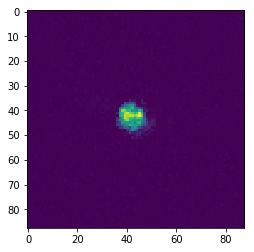

In [114]:
c = 20
img = output['real_space_final'][0]
plt.figure()
plt.imshow(np.abs(img)[c:-c,c:-c])
plt.show()

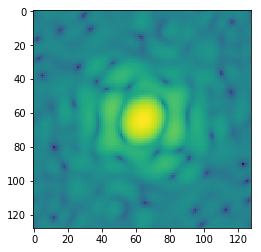

In [115]:
img = output['fourier_space_final'][0]
plt.figure()
plt.imshow(np.abs(img), norm=LogNorm())
plt.show()

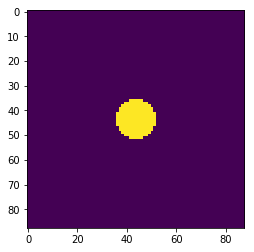

In [116]:
img = output['support_final'][0]
plt.figure()
plt.imshow(img[c:-c,c:-c])
plt.show()

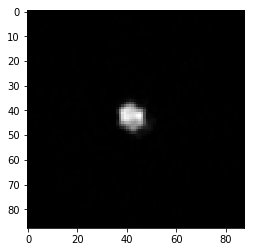

In [117]:
img = res['super_image']
plt.figure()
plt.imshow(np.abs(img)[c:-c,c:-c], cmap='gray')
plt.show()

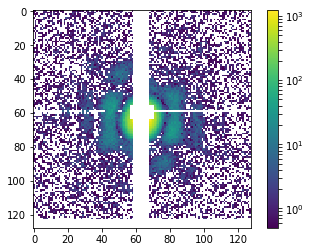

In [118]:
plt.figure()
plt.imshow(data_ds,norm=LogNorm())
plt.colorbar()
plt.show()

In [119]:
initial_support

16.0